In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
import re
%matplotlib inline

In [70]:
data = pd.read_csv('data/comments.csv.gz')

In [71]:
data.shape

(180687, 3)

In [72]:
data.is_gum.value_counts()

1.0    90633
0.0    90054
Name: is_gum, dtype: int64

### Length of comments (symbols)

In [73]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [74]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.064913358459663, 47.0)

In [75]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [76]:
sum(lenghts_symb)

13924628

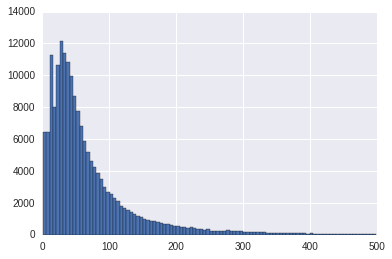

In [77]:
plt.hist(lenghts_symb[lenghts_symb < 500], bins=100);

In [78]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 500].shape[0] / lenghts_symb.shape[0] * 100, 500))

99.04% of comments are shorter than 500 symbols


In [79]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 20].shape[0] / lenghts_symb.shape[0] * 100, 15))

82.19% of comments are longer than 15 symbols


### Length of comments (words)

In [80]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [81]:
lenghts_word.mean(), np.median(lenghts_word)

(11.438432205969439, 7.0)

In [82]:
min(lenghts_word), max(lenghts_word)

(1, 1612)

In [83]:
sum(lenghts_word)

2066776

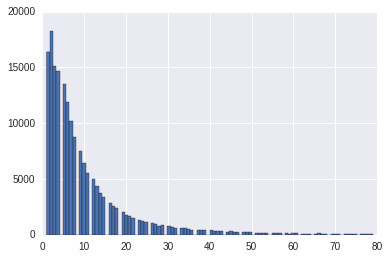

In [84]:
plt.hist(lenghts_word[lenghts_word < 80], bins=100);

In [85]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 80].shape[0] / lenghts_word.shape[0] * 100, 80))

99.04% of comments are shorter than 80 words


In [86]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 3].shape[0] / lenghts_word.shape[0] * 100, 3))

72.44% of comments are longer than 3 words


### Links

In [87]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [88]:
links[:5]

['[id99906417|Илья], http://prostitutki-voronezha.info/',
 'Вот, как раз на эту тему http://s02.yapfiles.ru/files/531066/SHkala_masshtabov_Vselennoy_v.2.swf Про масштабы вселенной, админы проигнорили мой пост, видимо про котят интереснее.....',
 'Она каким то образом пишет в вк? Значит у нее есть доступ к 2gis.ru',
 'http://www.zakonrf.info/koap/20.1/',
 'http://m.youtube.com/#/watch?feature=youtu.be&v=yfDOcUSLZ6o&desktop_uri=%2Fwatch%3Fv%3DyfDOcUSLZ6o%26feature%3Dyoutu.be\nДоставило, особенно комментарии. Спасители наши']

In [89]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.57% of comments contain links


## Baseline model

In [90]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(data.text.values)
y = data.is_gum.values

In [91]:
lr = lm.LogisticRegression()

In [92]:
np.random.seed(0)

### CV result

In [93]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52080136820649048, 0.012812570384976506)

### Overfitted result

In [96]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
lr.score(X, y)

0.64771123545136067

In [98]:
lr.coef_.argmax()

1096

In [99]:
vectorizer.get_feature_names()[1096]

'yulya'

## Preprocessing

In [100]:
comments = data[(lenghts_word < 80) & (lenghts_word > 3)]

In [101]:
comments.shape

(129171, 3)

In [102]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [103]:
comments_lenghts.argsort()[:10]

array([62662, 12532, 12533, 12551, 69195, 12767, 11304,  2805, 84262, 10001])

In [105]:
comments.text.values[62662]

'😡 😡 😡 😡'

In [106]:
comments.is_gum.value_counts()

0.0    65268
1.0    63903
Name: is_gum, dtype: int64

In [108]:
comments.text.values[102:104]

array([ '[id168803274|Артём], воооот) а у меня батя дальнобойщик. Я не понаслышке знаю что такое груженый тягач) в общем, мы друг друга поняли!)',
       '[id13014907|Сергей], когда воздух уходит из системы- машина растормаживается, т.е. все колёса блокируются. Тормоза на новых тягачах не отказывают. Это вам не КрАЗ'], dtype=object)

In [109]:
[t.split() for t in comments.text.values[102:104]]

[['[id168803274|Артём],',
  'воооот)',
  'а',
  'у',
  'меня',
  'батя',
  'дальнобойщик.',
  'Я',
  'не',
  'понаслышке',
  'знаю',
  'что',
  'такое',
  'груженый',
  'тягач)',
  'в',
  'общем,',
  'мы',
  'друг',
  'друга',
  'поняли!)'],
 ['[id13014907|Сергей],',
  'когда',
  'воздух',
  'уходит',
  'из',
  'системы-',
  'машина',
  'растормаживается,',
  'т.е.',
  'все',
  'колёса',
  'блокируются.',
  'Тормоза',
  'на',
  'новых',
  'тягачах',
  'не',
  'отказывают.',
  'Это',
  'вам',
  'не',
  'КрАЗ']]

In [110]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values

In [111]:
lr = lm.LogisticRegression()

In [112]:
np.random.seed(0)

In [113]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.51759298157147593, 0.010068387473288525)

In [114]:
lr.fit(X, y)
lr.score(X, y)

0.67061492130586586

## Replacing id

In [154]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))

In [155]:
comments_list[:5]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉']

## Emoji

In [156]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [157]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return True
    return False

In [158]:
def get_emoji(comment):
    ems = []
    for em in emojis:
        if em in comment:
            ems.append(em)
    return ems

In [159]:
comments_emoji = [c for c in comments_list if is_with_emoji(c)]

In [160]:
len(comments_emoji)

11243

In [133]:
emoji_from_comments = list(map(get_emoji, comments_list))

In [134]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments]

/home/digitman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [135]:
comments.head(10)

,from_id,text,is_gum,emojis
1,360037882,НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ...,0.0,💪
2,360037882,"[id34736142|Андрей], не имеет значение где ЮР,...",0.0,
3,360037882,"[id34736142|Андрей], где СК удобнее там и пров...",0.0,
4,360037882,Сегодня в 23:00 до 5:00 собираемся все НА АРЕН...,0.0,
5,360037882,"[id55153608|Федор], пошлиб да проявили смелост...",0.0,😉
6,360037882,"[id16867860|Дмитрий], любое ДТП есть страховой...",0.0,
7,360037882,"[id269199653|Евгений], что если кого то что то...",0.0,
8,360037882,"Норма у всех своя, а правила регулируют закон....",0.0,
11,360037882,"[id269199653|Евгений], да будет так",0.0,
13,360037882,Для особо одаренных есть ночные смены😀,0.0,😀


## Clearing comments

In [199]:
def clear_comments(comments, with_stemmer=False, with_lemmer=False, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    if with_emoji:
        emoji_from_comments = ' '.join(map(get_emoji, comments.text.values)))
    
    names_del = 0
    for comment in comments:
        if to_lower:
            comment = comment.lower()
        comment = comment.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            comment = [lemmer.parse(c)[0].normal_form for c in comment]
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

In [200]:
clear_coms = clear_comments(comments_list, min_word_len=3)

names del: 0


In [201]:
comments_list[10:15]

['adddresssation где купить можно, в поддержку отечественного продукта',
 'Опять эти пазики да как Вы уже задрали 😂😂😂😂😂😂',
 'adddresssation да и так понятно что встречный... Просто пазики и водителей везде тролят за их вождение а тут бац и он вообще не приделах',
 'Кто посоветует клуб для занятий по боксу...',
 'Нехуй тормозить перед большигрузами😀😂']

In [202]:
clear_coms[10:15]

['adddresssation где купить можно поддержку отечественного продукта',
 'опять эти пазики как уже задрали',
 'adddresssation так понятно что встречный просто пазики водителей везде тролят вождение тут бац вообще приделах',
 'кто посоветует клуб для занятий боксу',
 'нехуй тормозить перед большигрузами']

In [203]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(clear_coms)
y = comments.is_gum.values

In [208]:
vectorizer.get_feature_names()[1000:1010]

['вообщем',
 'вооот',
 'вопрос',
 'вопроса',
 'вопросам',
 'вопросе',
 'вопросов',
 'вопросом',
 'вопросу',
 'вопросы']

In [205]:
lr = lm.LogisticRegression()

In [206]:
np.random.seed(0)

In [207]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52562122593099969, 0.0095568967135199537)

In [209]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [210]:
lr.score(X, y)

0.64001207701419049

In [215]:
lr.coef_.argmin()

9288

In [216]:
vectorizer.get_feature_names()[9288]

'ухахаха'